Logs   
- [2023/03/08]   
  Restart this notebook if you change the scratch library

In [31]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple, List
from scratch.probability import Probability as prob
from scipy import special as sc_special

In [33]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({
  'font.size': 16,
  'grid.alpha': 0.25})

The *science* part of data science frequently involves forming and testing *hypotheses* about our data and the process that generate it.

## Statistical Hypothesis Testing

Hypothesis -> statistics (distributions) -> how likely the hypothesis holds

**Null hypothesis**, $H_0$: some default position    
**Alternative hypothesis**, $H_1$: other hypotheses that we would like to compare with $H_0$ 

## Example: Flipping a Coin

**Null hypothesis**, $H_0$: The coin is fair ($p = 0.5$)    
**Alternative hypothesis**, $H_1$: ($p \neq 0.5$)

In our test, we flip the coin at some number $n$ times, 
and count the nubmer of heads $X$.

In [3]:
def normal_approximation_to_binomial(
  n: int, p: float) -> Tuple[float, float]:

  """Returns mu and sigma corresponding to a Binomial(n, p)""" 
  mu = p * n
  sigma = np.sqrt(p * (1 - p) * n)
  return mu, sigma

In [4]:
# The normal cdf _is_ the probability the variable is below a threshold
normal_probability_below = prob.normal_cdf

In [5]:
# It's above the threshold if it's not below the threshold
def normal_probability_above(low: float, mu: float = 0, sigma: float = 1) -> float:
  """The probability that an N(mu, sigma) is greater than lo.""" 
  return 1 - prob.normal_cdf(low, mu, sigma)

# It's between if it's less than `high`, but not less than `low`
def normal_probability_between(low: float, high: float,
  mu: float = 0, sigma: float = 1) -> float:
  """The probability that an N(mu, sigma) is between `low` and `high`.""" 
  return prob.normal_cdf(high, mu, sigma) - prob.normal_cdf(low, mu, sigma)

# it's outside if it's not between
def normal_probability_outside(low: float, high: float, 
  mu: float = 0, sigma: float = 1) -> float:
  """The probability that an N(mu, sigma) is not between low and high.""" 
  return 1 - normal_probability_between(low, high, mu, sigma)


Find the upper, lower, or two-sided bounds given the probability
symmetric to the mean.

In [6]:
def normal_upper_bound(probability: float, mu: float = 0,
  sigma: float = 1) -> float:
  """Returns the z for which P(Z <= z) = probability""" 
  return prob.inverse_normal_cdf(probability, mu, sigma)

def normal_lower_bound(probability: float, mu: float = 0, 
  sigma: float = 1) -> float:
  """Returns the z for which P(Z >= z) = probability"""
  return prob.inverse_normal_cdf(1 - probability, mu, sigma)

def normal_two_sided_bounds(probability: float, mu: float = 0,
  sigma: float = 1) -> Tuple[float, float]:
  """
  Returns the symmetric (about the mean) bounds that contains
  the specified probability
  """  
  tail_probability = (1 - probability) / 2

  # upper bound should have tail_probability above it
  upper_bound = normal_lower_bound(tail_probability, mu, sigma)

  # lower bound should have tail_probability below it
  lower_bound = normal_upper_bound(tail_probability, mu, sigma)

  return lower_bound, upper_bound

### Type 1 error

Let's say that we choose to flip  the coind $n = 1,000$ times.
If our hyphotesis of fairness is true, $X$ (the number of head)
should be distributed approximately normally with mean $np = 1,000 (0.5) = 500$ and standard deviation ($\sqrt{np(1-p)} = \sqrt{1,000(0.5)(0.5)} = 15.81$

We need to make a decision about *significance* &mdash; how willing are to make a *type 1 error* ("false positive"), in which we reject $H_0$ even though it's true.


In [7]:
mu_0, sigma_0 = normal_approximation_to_binomial(1_000, 0.5)
mu_0, sigma_0

(500.0, 15.811388300841896)

Consider the test that rejects $H_0$ if $X$ fails outside the bounds
given by:

In [8]:
# significance level = 0.05 = 5%
lower_bound, upper_bound = normal_two_sided_bounds(0.95, mu_0, sigma_0)
print(f"lower bound: {lower_bound:.0f}")
print(f"upper_bound: {upper_bound:.0f}")

lower bound: 469
upper_bound: 531


Assumming $p$ really equals 0.5 (i.e., $H_0$ is true), 
there is just a 5% chance we observe an $X$ that lies outside this interval, which is the exact significance we wanted. 
Said differenelty, if $H_0$ is true, then, approximately 19 times
out of $20$, this test will give the correct result.

### Type 2 error

We are also often interested in the *power* of a test, which is
the probability of not making a *type 2 error* ("false negative"),
in which we fail to reject $H_0$ even though it's false.

We assume that the coind is slightly biased toward heads ($p = 0.55$)

In [9]:
# fail to reject H_0 means that we fall inside the interval of 95% bound.
# 95% bounds based on assumption p is 0.5 (H_0)
low, high = normal_two_sided_bounds(0.95, mu_0, sigma_0)

# actual mu and sigma based on p = 0.55
mu_1, sigma_1 = normal_approximation_to_binomial(1_000, 0.55)
print(f"mu_1: {mu_1}")
print(f"sigma_1: {sigma_1}")

# a type 2 error means we fail to reject the null hypothesis,
# which will happen when X is still in our original interval
type_2_probability = normal_probability_between(low, high, mu_1, sigma_1)
power = 1 - type_2_probability   # not making a type 2 error
power



mu_1: 550.0
sigma_1: 15.732132722552274


0.886548001295367

The next case, what happens to the *power* of the test, if the coin 
is not biased toward heads, or that $p \leq 0.5$.
In that case we want a *one-sided test* that rejects the null 
hypothesis when $X$ is much larger than 500 but not when $X$
is smaller than 500.

Null hypothesis ($H_0$): $p \leq 0.5$    
Alternative hypotehsis ($H_1$): $p > 0.5$   
(in fact we have $p = 0.55$)

In [10]:
# With 5% significance test (one-sided test)
# The result is smaller than two-sided test because we need more
# probability in the upper tail (5% only for high tail side)
high_one_sided = normal_upper_bound(0.95, mu_0, sigma_0)
print(f"high_one_sided: {high_one_sided:.0f}")

high_one_sided: 526


In [11]:
# a type 2 error means we fail to reject the null hypothesis 
# for this one-side test, the null hypothesis is p <= 0.5
# which will happen when X is still below the upper bound of
# original interval (p = 0.5)
type_2_probability_one_sided = normal_probability_below(high_one_sided, 
  mu_1, sigma_1)

power = 1 - type_2_probability_one_sided   # not making type 2 error 
                                           # one-sided
print(f"the power of the test: {power}")

the power of the test: 0.9363794803307173


Comparing to the previous one, the test is more powerful 
that it no longer reject $H_0 (p \leq 0.5)$  when $X$ is below
469 (which is very unlikely to happen if $H_1$ is true)
and instead reject $H_0$ when $X$ is between 526 and 531 
(which is somewhat likely to happen if $H_1$ is true)

In the above example $H_1$ is true (p = 0.55 > 0.5)
and we have high probability for that alternative hypothesis.




## p-Values

In [12]:
def two_sided_p_value(x: float, mu: float = 0, sigma: float = 1) -> float:
  """ 
  How likely are we to see a value at least as extreme as x (in either
  direction) if our values are from an N(mu, sigma)?
  """ 
  if x >= mu:
    # x is greater than mean, so the tail is everything greater than x
    return 2 * normal_probability_above(x, mu, sigma)

  else:
    # x is less than the mean, so the tail is everything less than x
    return 2 * normal_probability_below(x, mu, sigma)

If we were to see 530 heads, we could compute

In [13]:
# We use a value 529.5 instead of 530 because
# of continuity correction. It is better to estimate
# using P(529.5 <= X < 530.5) rather than  P(530 <= X <= 531)
two_sided_p_value(529.5, mu_0, sigma_0)


0.06207721579598835

A simulation to show this *p-value*

In [14]:
rng = np.random.default_rng(2023_03_23)

extreme_value_count = 0
for _ in range(1_000):
  num_heads = sum(1 if rng.random() < 0.5 else 0    # Count # of heads
                  for _ in range(1_000))            # in 1000 flips

  if num_heads >= 530 or num_heads <= 470:  # and count how oftern
    extreme_value_count += 1                # the # is `extreme`

# p-value was 0.062 => ~= 62 extreme values out of 1_000
print(f"extreme_value_count: {extreme_value_count}")

extreme_value_count: 60


Since the *p-value* = 0.062 is greater than our 5% significance,
we don't reject the null.

If we instead saw 532 heads, the *p-value* would be:

In [15]:
two_sided_p_value(531.5, mu_0, sigma_0)

0.046345287837786575

For one-sided test

In [16]:
upper_p_value = normal_probability_above 
lower_p_value = normal_probability_below

In [17]:
# If we saw 525 heads (one-sided test)
# We wouldn't reject the null (0.06 > 0.05)
upper_p_value(524.5, mu_0, sigma_0)


0.06062885772582072

In [18]:
# If we saw 527 heads (one-sided test)
# we would reject the null (0.04 < 0.05)
upper_p_value(526.5, mu_0, sigma_0)

0.04686839508859242

## Confidence Intervals

For example, we want to know the coin is fair or not.   
By flipping 1_000 times, we observe 525 heads.   
We don't know the $p$, and we use our estimate

In [19]:
p_hat = 525 / 1_000
mu = p_hat
sigma = np.sqrt(p_hat * (1 - p_hat) / 1000)

print(f"mu: {mu}")
print(f"sigma: {sigma}")

# Using 95% cconfident
normal_two_sided_bounds(0.95, mu, sigma)

mu: 0.525
sigma: 0.015791611697353755


(0.4940490278129096, 0.5559509721870904)

In particular, we do not conclude that the coins is unfair, since
0.5 falls within our confidence interval.

If instead, we had seen 540 heads:

In [20]:
p_hat = 540 / 1_000
mu = p_hat
sigma = np.sqrt(p_hat * (1 - p_hat) / 1_000)
normal_two_sided_bounds(0.95, mu, sigma)

(0.5091095927295919, 0.5708904072704082)

Here, "fair coin" doesn't lie in the confidence interval. 
(The "fair coin" hypothesis doesn't pass a test that you would
expect it to pass 95% of the time if it were true)

## p-Hacking 

You can set out the data to find something "significant" result.   
It can be done by remove outlier (like in the section Correlation)

In [21]:
def run_experiment(rng) -> List[bool]:
  """Flips a fair coin 1_000 times, True = heads, False = tails""" 
  return rng.random(1_000) < 0.5

def reject_fairness(experiment: List[bool]) -> bool:
  """
  Using the 5% significance levels.
  Interval is computer from `normal_two_sided_bounds(0.95, mu_0, sigma_0)`
  where mu_0, sigma_0 are computed from
  mu_0, sigma_0 = normal_approximation_to_binomial(1_000, 0.5)
  """ 
  num_heads = sum(experiment) 
  return num_heads < 469 or num_heads > 531

In [22]:
rng = np.random.default_rng(2023_03_23)
experiments = [run_experiment(rng) for _ in range(1_000)]
num_rejections = len([experiment for experiment in experiments
                     if reject_fairness(experiment)])

# 46 rejections from 1_000 experiments
print(f"num_rejections: {num_rejections}")  
print(num_rejections / 1000)  # approximately 5%

num_rejections: 46
0.046


Do not tweak the data to get better significant *p-value*
if you want to do good *science*.

## Example: Running an A/B Test

In [23]:
def estimated_parameters(N: int, n: int) -> Tuple[float, float]:
  p = n / N
  sigma = np.sqrt(p * (1 - p) / N)
  return p, sigma

In [24]:
def a_b_test_statistic(N_A: int, n_A: int, N_B: int, n_B: int) -> float:
  p_A, sigma_A = estimated_parameters(N_A, n_A)
  p_B, sigma_B = estimated_parameters(N_B, n_B)
  return (p_B - p_A) / np.sqrt(sigma_A ** 2 + sigma_B ** 2)

If "tastes great" gets 200 clicks out of 1,000 views and "less bias" gets 
180 clicks out of 1,000 views, the statistics equals:

In [29]:
z = a_b_test_statistic(1_000, 200, 1_000, 180)
z, two_sided_p_value(z)

(-1.1403464899034472, 0.2541419765422359)

If "less bias" only got 150 clicks, we would have:

In [30]:
z = a_b_test_statistic(1_000, 200, 1_000, 150)
z, two_sided_p_value(z)

(-2.948839123097944, 0.003189699706216853)

## Bayesian Inference

In [45]:
def B(alpha: float, beta: float) -> float:
  """A normalizing constant so that the total probability is 1""" 
  return sc_special.gamma(alpha) * sc_special.gamma(beta) \
    / sc_special.gamma(alpha + beta)

def beta_pdf(x: float, alpha: float, beta: float) -> float:
  pdf = np.zeros_like(x)
  logical_index = np.logical_and(x >= 0, x <= 1)
  pdf[logical_index] = x[logical_index]**(alpha - 1) \
    * (1 - x[logical_index])**(beta - 1) / B(alpha, beta)
  return pdf

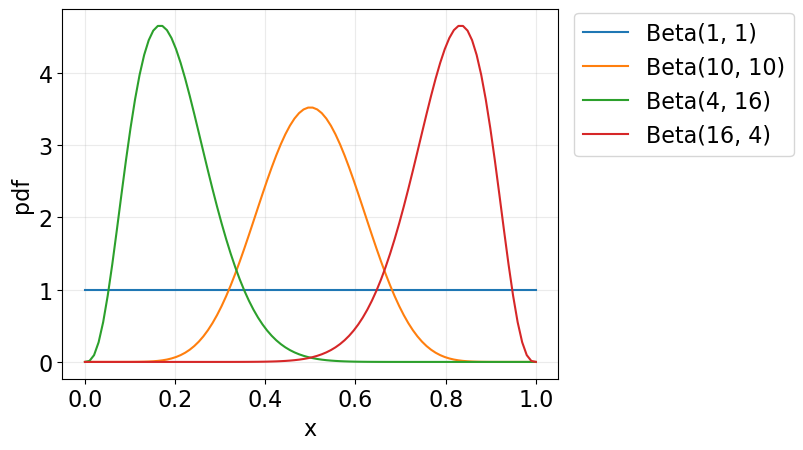

In [56]:
fig, ax = plt.subplots()

N_data_points = 100
x_data = np.linspace(0, 1, N_data_points)

beta_pdf_config = [
  [1, 1], [10, 10], [4, 16], [16, 4]] 

for alpha, beta in beta_pdf_config:
  y_data = beta_pdf(x_data, alpha, beta)
  ax.plot(x_data, y_data, label=f"Beta({alpha}, {beta})")

ax.set_xlabel("x")
ax.set_ylabel("pdf")
ax.grid("on")
ax.legend(loc="upper left", bbox_to_anchor=[1.01, 1.02])

plt.show(fig)